In [6]:
import os
import sys
import argparse
from os.path import dirname, realpath


In [7]:
sys.path.append("./src/")
sys.path.append(dirname(dirname(realpath(os.getcwd()))))

In [8]:
%run load_Results.py

In [9]:
wts01 = np.where(gold1 == 1, 4/(np.mean(.064)* (1-mp1) ), 1/ mp1)
wts02 = np.where(gold2 == 1, 4/(np.mean(.064)* (1-mp2) ), 2/ mp2)
wts03 = np.where(gold3 == 1, 4/(np.mean(.064)* (1-mp3) ), 3/ mp3)
wts04 = np.where(gold4 == 1, 4/(np.mean(.064)* (1-mp4) ), 4/ mp4)


In [10]:
wts1234 = np.concatenate((wts01,wts02, wts03, wts04))
y1234 = np.concatenate((gold1,gold2, gold3, gold4))
lo1234 = logit( np.concatenate((mp1,mp2, mp3, mp4)) )
tlo1234 = logit( np.concatenate((tp1,tp2, tp3, tp4)) )
ti = np.concatenate((np.ones(len(mp1)), 2*np.ones(len(mp2)), 3*np.ones(len(mp3)), 4*np.ones(len(mp4))))
tti = np.concatenate((np.ones(len(tp1)), 2*np.ones(len(tp2)), 3*np.ones(len(tp3)), 4*np.ones(len(tp4))))

In [11]:
def weighted_temp2_scaling (logits, y, wts):
    def temperature_obj(t):
        temp_logits =   (logits  ) *  t [0]  + t[1]
        probs = expit(temp_logits)
        return log_loss(y, probs, sample_weight=wts)    
    res = minimize (temperature_obj,x0 = [.1,.1])
    return res.x
def temp_pred2 (alpha,  test_logit):    
    logi =  (test_logit )* alpha[0]     + alpha[1]
    proba = expit ( logi   ) #*tt.x[5]    
    return proba

In [12]:
alpha_0_1234  = weighted_temp2_scaling(  lo1234 , y1234,  wts1234)


In [13]:
pc = temp_pred2(alpha_0_1234, lo1234 )

(array([35593.,  6756.,  3954.,  2573.,  1803.,  1341.,  1033.,   724.,
          383.,   120.]),
 array([2.57792036e-04, 8.99829500e-02, 1.79708108e-01, 2.69433266e-01,
        3.59158424e-01, 4.48883582e-01, 5.38608740e-01, 6.28333898e-01,
        7.18059056e-01, 8.07784214e-01, 8.97509372e-01]),
 <BarContainer object of 10 artists>)

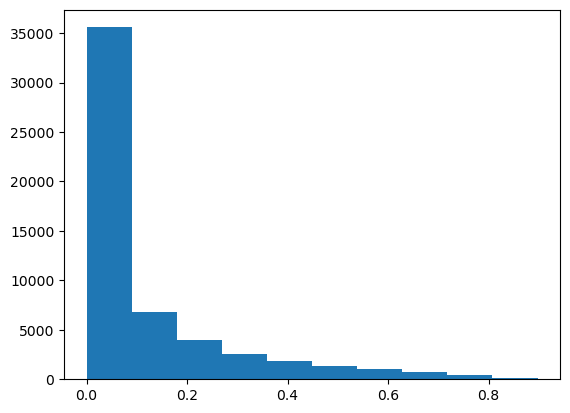

In [14]:
plt.hist(pc)

In [15]:
wp1 = ( pc [ti==1])**1
wp2 = ( pc [ti==2]) **1
wp3 = ( pc [ti==3]) **1
wp4 =  (pc [ti==4])**1
np1 =  ((1-pc) [ti==1])**1
np2 =  ((1-pc) [ti==2])**1
np3 =  ((1-pc) [ti==3])**1
np4 =  ((1-pc) [ti==4])**1

In [43]:
wts1 = np.where(gold1 == 1, 1/( np1 *np.mean(gold1))**1, 1/ wp1)
wts2 = np.where(gold2 == 1, 1/( np2 *np.mean(gold2))**1, 2/ wp2)
wts3 = np.where(gold3 == 1, 1/( np3 *np.mean(gold3))**1, 3/wp3 )
wts4 = np.where(gold4 == 1, 1/( np4 *np.mean(gold4))**1, 4/wp4 )

In [44]:
def temperature_multi_w(l1, l2,l3,l4, y1, y2, y3, y4, w1, w2, w3, w4):
    def temperature_obj(t):
        logi_1 = (l1* t[5]  +  t[1])  
        logi_2 = (l2 * t[6]  +  t[2])  
        logi_3 = (l3 * t[7] +  t[3])  
        logi_4 = (l4 * t[8] +  t[4])  
        
        p1  = expit (t[0] * logi_1  )  
        p2  = expit ( t[0] *  logi_2  )  
        p3  = expit (t[0] *  logi_3  )  
        p4  = expit ( t[0] * logi_4  ) 
        total_loss=log_loss(y1,p1,sample_weight=w1)+log_loss(y2,p2,sample_weight=w2)+log_loss(y3,p3,sample_weight=w3)+log_loss(y4,p4,sample_weight=w4)        
        return   total_loss
    r = minimize (temperature_obj, x0 = [.1, .1, .1,.1, 
                                         .1, .1,.1, .1, .1  ] )    
    return  r

In [45]:
tt  = temperature_multi_w( logit(mp1), logit(mp2), logit(mp3), logit(mp4),
                          gold1, gold2, gold3, gold4, wts1, wts2, wts3, wts4  )

In [46]:
tt['message']

'Optimization terminated successfully.'

In [47]:
def temp_pred  ( j1,j2, test_logit):    
    logi =  ( test_logit * j2    + j1    )  
    proba = expit (  logi * tt.x[0]  )  
    return proba

In [48]:
cal_1 = temp_pred(tt.x[1],tt.x[5], logit(tp1) )
cal_2 = temp_pred(tt.x[2],tt.x[6], logit(tp2) )
cal_3 = temp_pred(tt.x[3],tt.x[7], logit(tp3) )
cal_4 = temp_pred(tt.x[4],tt.x[8], logit(tp4) )

y1, p1 = calibration_curve(M_test1['golds'], cal_1 , n_bins = 400)
y2, p2 = calibration_curve(M_test2['golds'], cal_2 , n_bins = 310)
y3, p3 =calibration_curve(M_test3['golds'], cal_3 , n_bins = 250)
y4, p4 = calibration_curve(M_test4['golds'], cal_4 , n_bins = 250)

In [49]:
p4_ = p4 [y4>0]
y4_ = y4 [y4>0]
p3_ = p3 [y3>0]
y3_ = y3 [y3>0]
p2_ = p2 [y2>0]
y2_ = y2 [y2>0]
p1_ = p1 [y1>0]
y1_ = y1 [y1>0]

In [50]:
fig_folder = 'C:/Users/VHANYNHeT/Desktop/PI04/Figures'

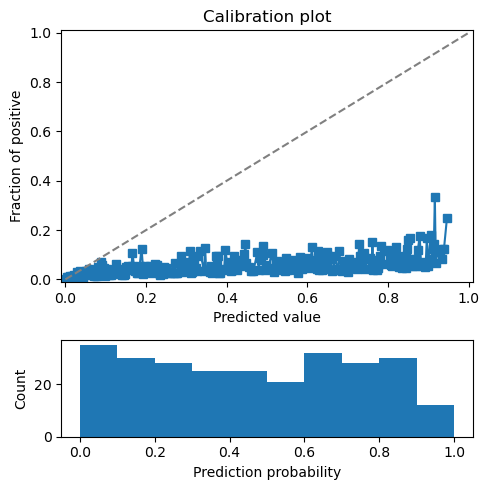

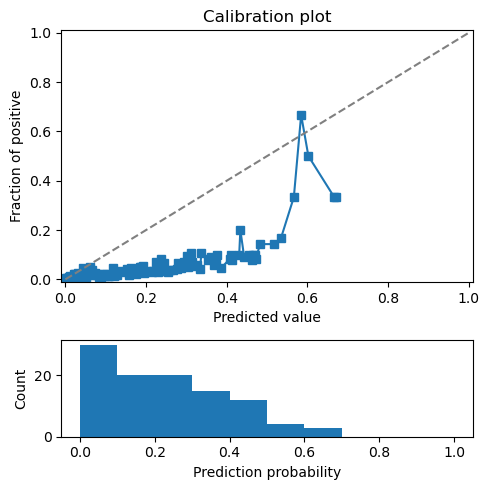

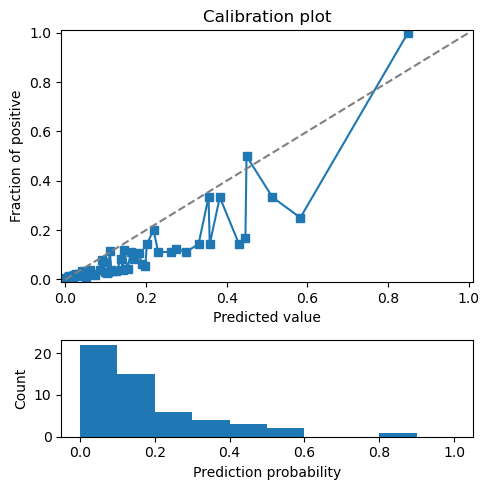

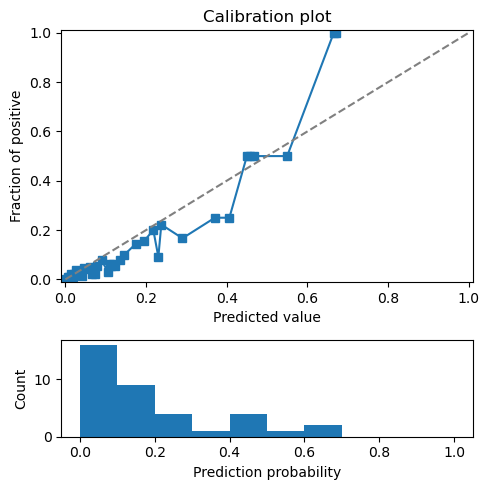

In [51]:
plot1 = plotter(p1_, y1_)
plot2 = plotter(p2_, y2_)
plot3 = plotter(p3_, y3_)
plot4 = plotter(p4_, y4_)

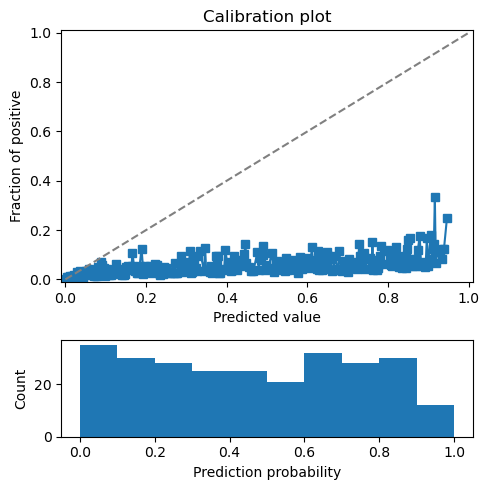

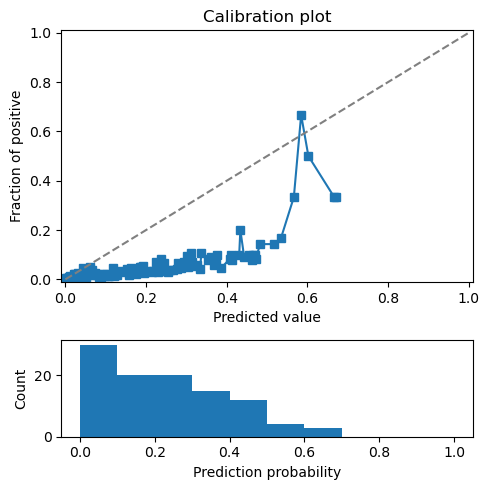

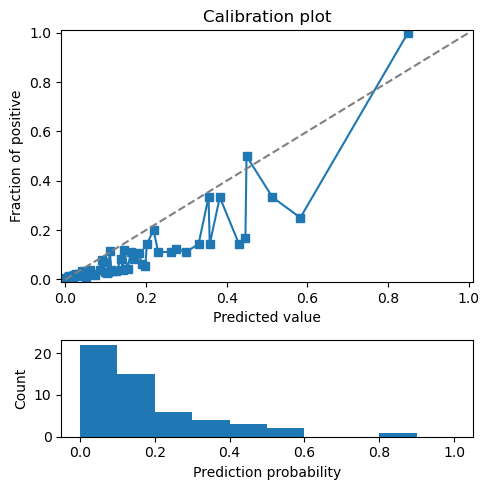

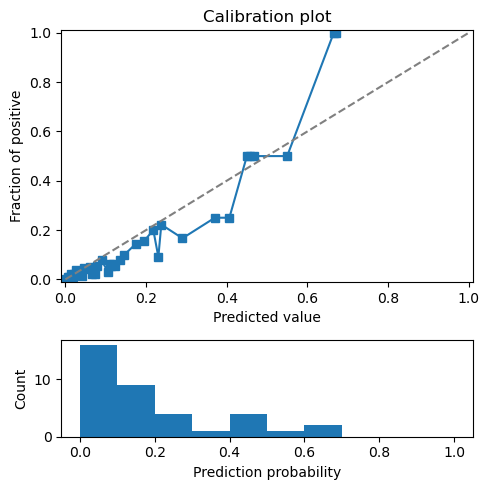

In [53]:
fig_folder = 'C:/Users/VHANYNHeT/Desktop/PI04/Figures'
plot1 = plotter(p1_, y1_)
plot1.savefig(os.path.join(fig_folder, 'origcal1.png'), bbox_inches='tight')
plot2 = plotter(p2_, y2_)
plot2.savefig(os.path.join(fig_folder, 'origcal2.png'), bbox_inches='tight')
plot3 = plotter(p3_, y3_)
plot3.savefig(os.path.join(fig_folder, 'origcal3.png'), bbox_inches='tight')
plot4 = plotter(p4_, y4_)
plot4.savefig(os.path.join(fig_folder, 'origcal4.png'), bbox_inches='tight')


In [931]:
plot1.savefig(os.path.join(fig_folder, 'cal1.png'), bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

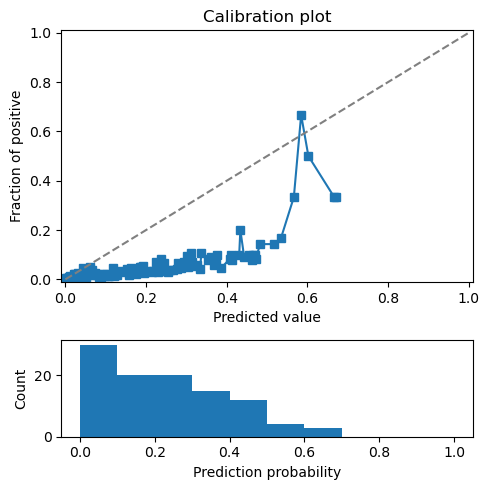

In [883]:
plot2 = plotter(p2_, y2_)

In [884]:
plot2.savefig(os.path.join(fig_folder, 'cal2.png'), bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

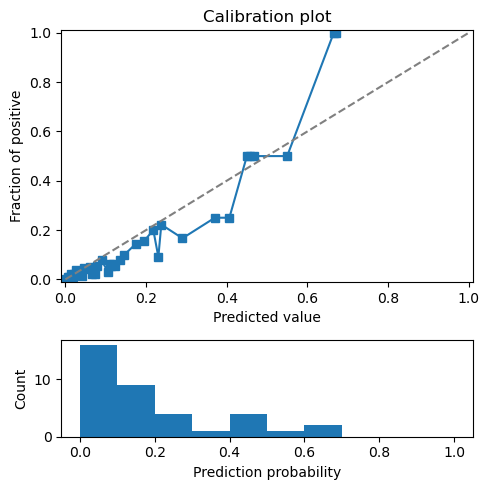

In [830]:
plot4 = plotter(p4_, y4_)

In [831]:
#plot4.savefig(os.path.join(fig_folder, 'cal4.png'), bbox_inches='tight')


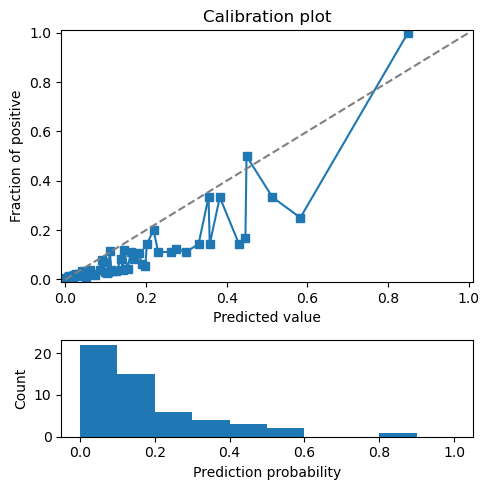

In [832]:
plot3=plotter(p3_, y3_)

In [790]:
#plot3.savefig(os.path.join(fig_folder, 'cal3.png'), bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

In [731]:
import sklearn
from sklearn.metrics import confusion_matrix

In [628]:
[sklearn.metrics.roc_auc_score(tgold4,  tp4 , average = 'samples'),
sklearn.metrics.roc_auc_score(tgold3,  tp3 , average = 'samples'),
sklearn.metrics.roc_auc_score(tgold2,  tp2 , average = 'samples'),
sklearn.metrics.roc_auc_score(tgold1,  tp1 , average = 'samples')]


[0.754709382855384, 0.7132108023602834, 0.6764938403022082, 0.6667921165559247]

In [629]:
( confusion_matrix (tgold1,  cal_1>.5) )

array([[11880,  3772],
       [  279,   201]], dtype=int64)

In [630]:
( confusion_matrix (tgold2,  cal_2>.5) )

array([[13753,   253],
       [  212,     8]], dtype=int64)

In [631]:
( confusion_matrix (tgold3,  cal_3>.5) )

array([[12584,    92],
       [  150,     3]], dtype=int64)

In [632]:
( confusion_matrix (tgold4,  cal_4>.5) )

array([[11550,    30],
       [   98,     3]], dtype=int64)